In [2]:
!pip install tensorflow # pour ceux qui l'ont pas 

Defaulting to user installation because normal site-packages is not writeable


ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import ast

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

from lightgbm import LGBMClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

from sklearn.impute import SimpleImputer


In [4]:
tracks = pd.read_csv("supervised_music_challenge_data/tracks.tsv", sep="\t", dtype={"track_id": str})
echonest = pd.read_csv("supervised_music_challenge_data/echonest_features.tsv", sep="\t", dtype={"track_id": str})
spectral = pd.read_csv("supervised_music_challenge_data/spectral_features.tsv", sep="\t", dtype={"track_id": str})
genres = pd.read_csv("supervised_music_challenge_data/genres.csv")


In [5]:
print("tracks_columns :", tracks.columns)
print("echonest_columns :", echonest.columns)
print("spectral_columns :", spectral.columns)   
print("genres_columns :", genres.columns)

tracks_columns : Index(['track_id', 'album_title', 'album_tracks', 'artist_latitude',
       'artist_longitude', 'artist_name', 'duration', 'favorites', 'genre_top',
       'genres', 'genres_all', 'interest', 'listens', 'title'],
      dtype='object')
echonest_columns : Index(['track_id', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'liveness', 'speechiness', 'tempo', 'valence'],
      dtype='object')
spectral_columns : Index(['track_id', 'spectral_bandwidth_kurtosis_01',
       'spectral_bandwidth_max_01', 'spectral_bandwidth_mean_01',
       'spectral_bandwidth_median_01', 'spectral_bandwidth_min_01',
       'spectral_bandwidth_skew_01', 'spectral_bandwidth_std_01',
       'spectral_centroid_kurtosis_01', 'spectral_centroid_max_01',
       'spectral_centroid_mean_01', 'spectral_centroid_median_01',
       'spectral_centroid_min_01', 'spectral_centroid_skew_01',
       'spectral_centroid_std_01', 'spectral_rolloff_kurtosis_01',
       'spectral_rolloff_max_01',

In [6]:
def clean_cols(df):
    # Standardize column names
    df.columns = (df.columns
                    .str.lower()
                    .str.strip()
                    .str.replace(" ", "_")
                    .str.replace("-", "_")
                    .str.replace(r"[^a-zA-Z0-9_]", "", regex=True))
    return df
        
tracks = clean_cols(tracks)
echonest = clean_cols(echonest)
spectral = clean_cols(spectral)
genres = clean_cols(genres)


In [7]:
df = tracks.merge(echonest, on="track_id", how="left") \
           .merge(spectral, on="track_id", how="left")


In [8]:
#df.to_csv("tracks_merged.csv", index=False) # Les 3 fichiers merged 

In [9]:
#Création de colonnes pour les genres

genres_df = genres.rename(columns={
    "genre_id": "id",
    "genre_title": "name"
})

# dictionnaire : id -> nom
id_to_name = dict(zip(genres_df["id"], genres_df["name"]))




In [10]:
type(df.loc[0, "genres"])


str

In [11]:
df["genres"] = df["genres"].apply(ast.literal_eval)
df["genres_all"] = df["genres_all"].apply(ast.literal_eval)


In [12]:
def ids_to_names(id_list):
    return [id_to_name.get(i, "UNKNOWN") for i in id_list]


In [13]:
df["genres_names"] = df["genres"].apply(ids_to_names)
df["genres_all_names"] = df["genres_all"].apply(ids_to_names)


In [14]:
df[["genre_top", "genres_names", "genres_all_names"]].head()


,genre_top,genres_names,genres_all_names
0,Hip-Hop,[Hip-Hop],[Hip-Hop]
1,Hip-Hop,[Hip-Hop],[Hip-Hop]
2,Hip-Hop,[Hip-Hop],[Hip-Hop]
3,Hip-Hop,[Hip-Hop],[Hip-Hop]
4,Hip-Hop,[Hip-Hop],[Hip-Hop]


In [15]:
# 1. Informations générales
print("Shape du dataset:", df.shape)
print("\nTypes de données:")
print(df.dtypes)


Shape du dataset: (99995, 45)

Types de données:
track_id                           object
album_title                        object
album_tracks                        int64
artist_latitude                   float64
artist_longitude                  float64
artist_name                        object
duration                            int64
favorites                           int64
genre_top                          object
genres                             object
genres_all                         object
interest                            int64
listens                             int64
title                              object
acousticness                      float64
danceability                      float64
energy                            float64
instrumentalness                  float64
liveness                          float64
speechiness                       float64
tempo                             float64
valence                           float64
spectral_bandwidth_kurtosis

In [16]:
# 2. Valeurs manquantes
print("\n=== VALEURS MANQUANTES ===")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Percentage': missing_pct
}).sort_values('Percentage', ascending=False)
print(missing_df[missing_df['Missing_Count'] > 0])




=== VALEURS MANQUANTES ===
                  Missing_Count  Percentage
speechiness               89587   89.591480
valence                   89463   89.467473
danceability              89461   89.465473
energy                    89442   89.446472
liveness                  89442   89.446472
acousticness              89442   89.446472
tempo                     89442   89.446472
instrumentalness          89442   89.446472
artist_longitude          59788   59.790990
artist_latitude           59788   59.790990
genre_top                 55362   55.364768
album_title                 911    0.911046
title                         1    0.001000


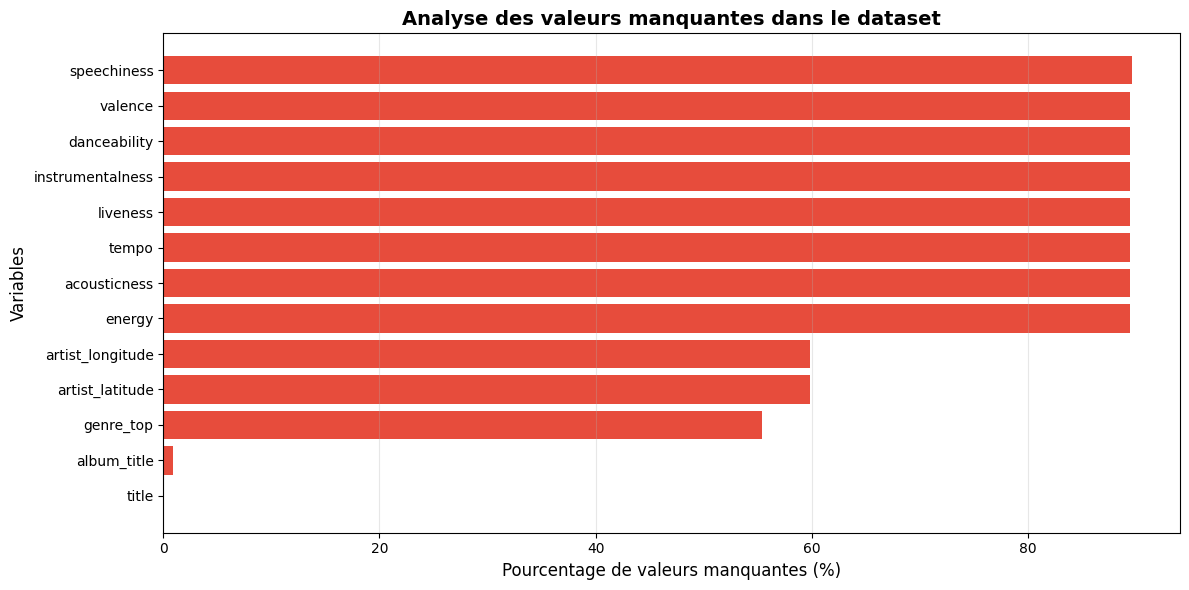

In [17]:
# Filtrer et trier
missing_to_plot = missing_df[missing_df['Percentage'] > 0].sort_values('Percentage')

# Créer le graphique
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(missing_to_plot.index, missing_to_plot['Percentage'], color='#e74c3c')

ax.set_xlabel('Pourcentage de valeurs manquantes (%)', fontsize=12)
ax.set_ylabel('Variables', fontsize=12)
ax.set_title('Analyse des valeurs manquantes dans le dataset', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


=== CORRÉLATION ENTRE MISSING VALUES ===

Nombre de variables avec missing values: 13

Corrélations fortes (> 0.5):
  speechiness <-> valence: 0.993
  speechiness <-> danceability: 0.993
  speechiness <-> energy: 0.992
  speechiness <-> liveness: 0.992
  speechiness <-> acousticness: 0.992
  speechiness <-> tempo: 0.992
  speechiness <-> instrumentalness: 0.992
  valence <-> danceability: 1.000
  valence <-> energy: 0.999
  valence <-> liveness: 0.999
  valence <-> acousticness: 0.999
  valence <-> tempo: 0.999
  valence <-> instrumentalness: 0.999
  danceability <-> energy: 0.999
  danceability <-> liveness: 0.999
  danceability <-> acousticness: 0.999
  danceability <-> tempo: 0.999
  danceability <-> instrumentalness: 0.999
  energy <-> liveness: 1.000
  energy <-> acousticness: 1.000
  energy <-> tempo: 1.000
  energy <-> instrumentalness: 1.000
  liveness <-> acousticness: 1.000
  liveness <-> tempo: 1.000
  liveness <-> instrumentalness: 1.000
  acousticness <-> tempo: 1.000
  a

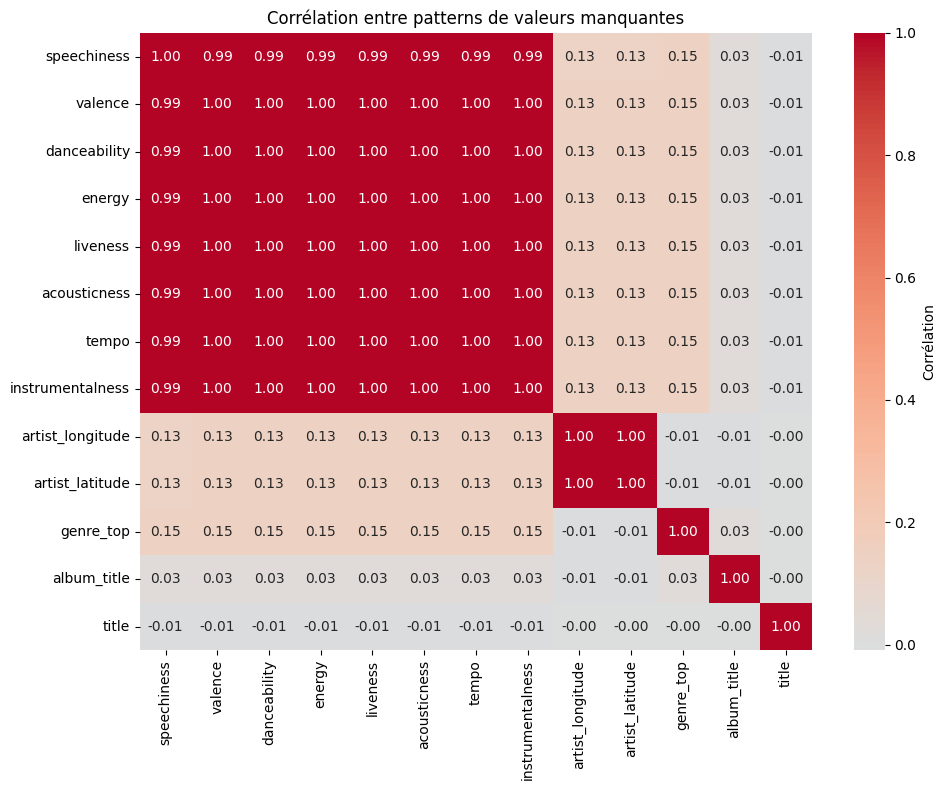

In [18]:
# Analyser si les missing values sont corrélés entre variables
print("\n=== CORRÉLATION ENTRE MISSING VALUES ===")
missing_cols = missing_df[missing_df['Missing_Count'] > 0].index.tolist()

if len(missing_cols) > 1:
    # Créer une matrice binaire (1 = missing, 0 = present)
    missing_matrix = df[missing_cols].isnull().astype(int)
    
    # Calculer la corrélation
    missing_corr = missing_matrix.corr()
    
    print(f"\nNombre de variables avec missing values: {len(missing_cols)}")
    print("\nCorrélations fortes (> 0.5):")
    
    # Afficher seulement les corrélations fortes
    for i in range(len(missing_corr.columns)):
        for j in range(i+1, len(missing_corr.columns)):
            corr_val = missing_corr.iloc[i, j]
            if abs(corr_val) > 0.5:
                print(f"  {missing_corr.columns[i]} <-> {missing_corr.columns[j]}: {corr_val:.3f}")
    
    # Heatmap si pas trop de variables
    if len(missing_cols) <= 15:
        import seaborn as sns
        
        fig, ax = plt.subplots(figsize=(10, 8))
        sns.heatmap(missing_corr, annot=True, fmt='.2f', cmap='coolwarm', 
                    center=0, ax=ax, cbar_kws={'label': 'Corrélation'})
        plt.title('Corrélation entre patterns de valeurs manquantes')
        plt.tight_layout()
        plt.show()
else:
    print("Une seule variable a des missing values, pas de corrélation à calculer.")

In [19]:
# 3. Doublons
print(f"\nNombre de doublons (track_id): {df['track_id'].duplicated().sum()}")




Nombre de doublons (track_id): 0


In [20]:
# 4. Statistiques descriptives
print("\n=== STATISTIQUES DESCRIPTIVES ===")
print(df[['duration', 'listens', 'interest', 'favorites']].describe())




=== STATISTIQUES DESCRIPTIVES ===
           duration        listens      interest     favorites
count  99995.000000   99995.000000  9.999500e+04  99995.000000
mean     278.034522    2403.072944  3.628631e+03      3.239962
std      294.940279    8234.085292  1.957852e+04     13.863871
min        0.000000       0.000000  2.000000e+00      0.000000
25%      151.000000     305.000000  6.020000e+02      0.000000
50%      218.000000     797.000000  1.333000e+03      1.000000
75%      307.000000    2085.000000  3.117000e+03      3.000000
max    11030.000000  543252.000000  3.293557e+06   1482.000000


In [21]:
print("\n" + "="*60)
print("DÉTECTION D'INCOHÉRENCES")
print("="*60)

# 1. DURÉE (variable cible pour Task 3)
print("\n--- DURÉE (duration) ---")
print(f"Durées négatives: {(df['duration'] < 0).sum()}")
print(f"Durées nulles (= 0): {(df['duration'] == 0).sum()}")
print(f"Durées très courtes (< 30s): {(df['duration'] < 30).sum()}")
print(f"Durées très longues (> 600s = 10min): {(df['duration'] > 600).sum()}")
print(f"Durées extrêmes (> 3600s = 1h): {(df['duration'] > 3600).sum()}")
print(f"\nMin duration: {df['duration'].min()}s")
print(f"Max duration: {df['duration'].max()}s")

# 2. COORDONNÉES GPS
print("\n--- COORDONNÉES GPS ---")
if 'artist_latitude' in df.columns and 'artist_longitude' in df.columns:
    print(f"Latitudes hors [-90, 90]: {((df['artist_latitude'] < -90) | (df['artist_latitude'] > 90)).sum()}")
    print(f"Longitudes hors [-180, 180]: {((df['artist_longitude'] < -180) | (df['artist_longitude'] > 180)).sum()}")
    print(f"Coordonnées (0, 0) - probablement invalides: {((df['artist_latitude'] == 0) & (df['artist_longitude'] == 0)).sum()}")

# 3. FEATURES ECHONEST (doivent être entre 0 et 1)
print("\n--- FEATURES ECHONEST (doivent être [0, 1]) ---")
audio_features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                  'liveness', 'speechiness', 'valence']

for feat in audio_features:
    if feat in df.columns:
        out_of_range = ((df[feat] < 0) | (df[feat] > 1)).sum()
        if out_of_range > 0:
            print(f"  ⚠️ {feat} hors [0,1]: {out_of_range} valeurs")
        else:
            print(f"  ✓ {feat}: OK")

# 4. TEMPO (devrait être positif et raisonnable)
print("\n--- TEMPO ---")
if 'tempo' in df.columns:
    print(f"Tempo négatif: {(df['tempo'] < 0).sum()}")
    print(f"Tempo = 0: {(df['tempo'] == 0).sum()}")
    print(f"Tempo très élevé (> 300 BPM): {(df['tempo'] > 300).sum()}")
    print(f"Range: [{df['tempo'].min():.1f}, {df['tempo'].max():.1f}] BPM")

# 5. FEATURES SPECTRALES (vérifier valeurs infinies/NaN)
print("\n--- FEATURES SPECTRALES ---")
spectral_cols = [col for col in df.columns if 'spectral' in col]
if spectral_cols:
    print(f"Valeurs infinies: {np.isinf(df[spectral_cols]).sum().sum()}")
    print(f"NaN dans spectrales (en plus des missing): {df[spectral_cols].isna().sum().sum()}")
    
    # Vérifier valeurs négatives (certaines features peuvent être négatives)
    negative_spectral = (df[spectral_cols] < 0).sum().sum()
    print(f"Valeurs négatives: {negative_spectral}")

# 6. STATISTIQUES D'ÉCOUTE
print("\n--- STATISTIQUES D'ÉCOUTE ---")
if 'listens' in df.columns:
    print(f"Listens négatifs: {(df['listens'] < 0).sum()}")
    print(f"Listens = 0: {(df['listens'] == 0).sum()}")
    
if 'interest' in df.columns:
    print(f"Interest négatif: {(df['interest'] < 0).sum()}")
    print(f"Interest = 0: {(df['interest'] == 0).sum()}")

if 'favorites' in df.columns:
    print(f"Favorites négatifs: {(df['favorites'] < 0).sum()}")

# 7. GENRE_TOP (variable cible Task 1)
print("\n--- GENRE_TOP (target Task 1) ---")
print(f"Genre_top manquants: {df['genre_top'].isnull().sum()}")
print(f"Genres uniques: {df['genre_top'].nunique()}")


DÉTECTION D'INCOHÉRENCES

--- DURÉE (duration) ---
Durées négatives: 0
Durées nulles (= 0): 4
Durées très courtes (< 30s): 1754
Durées très longues (> 600s = 10min): 5527
Durées extrêmes (> 3600s = 1h): 123

Min duration: 0s
Max duration: 11030s

--- COORDONNÉES GPS ---
Latitudes hors [-90, 90]: 0
Longitudes hors [-180, 180]: 0
Coordonnées (0, 0) - probablement invalides: 0

--- FEATURES ECHONEST (doivent être [0, 1]) ---
  ✓ acousticness: OK
  ✓ danceability: OK
  ✓ energy: OK
  ✓ instrumentalness: OK
  ✓ liveness: OK
  ✓ speechiness: OK
  ✓ valence: OK

--- TEMPO ---
Tempo négatif: 0
Tempo = 0: 19
Tempo très élevé (> 300 BPM): 0
Range: [0.0, 251.1] BPM

--- FEATURES SPECTRALES ---
Valeurs infinies: 0
NaN dans spectrales (en plus des missing): 0
Valeurs négatives: 94478

--- STATISTIQUES D'ÉCOUTE ---
Listens négatifs: 0
Listens = 0: 1
Interest négatif: 0
Interest = 0: 0
Favorites négatifs: 0

--- GENRE_TOP (target Task 1) ---
Genre_top manquants: 55362
Genres uniques: 16


In [22]:
# Statistiques descriptives des variables numériques :
# - moyenne, écart-type, min, max, quartiles

numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[numeric_cols].describe().T  # .T pour avoir une vue plus lisible



,count,mean,std,min,25%,50%,75%,max
album_tracks,99995.0,19.908645,40.510849,-1.000000e+00,7.000000,11.000000,18.000000,6.520000e+02
artist_latitude,40207.0,39.967832,18.766913,-4.587450e+01,39.271398,41.823989,50.079079,6.728601e+01
artist_longitude,40207.0,-35.443236,65.670545,-1.575269e+02,-78.868915,-72.669067,5.007986,1.752770e+02
duration,99995.0,278.034522,294.940279,0.000000e+00,151.000000,218.000000,307.000000,1.103000e+04
favorites,99995.0,3.239962,13.863871,0.000000e+00,0.000000,1.000000,3.000000,1.482000e+03
interest,99995.0,3628.631112,19578.522967,2.000000e+00,602.000000,1333.000000,3117.000000,3.293557e+06
listens,99995.0,2403.072944,8234.085292,0.000000e+00,305.000000,797.000000,2085.000000,5.432520e+05
acousticness,10553.0,0.489379,0.384781,9.491000e-07,0.070923,0.486664,0.897625,9.957965e-01
danceability,10534.0,0.506784,0.189812,5.143514e-02,0.367335,0.511994,0.651299,9.686447e-01
energy,10553.0,0.541650,0.274799,2.028170e-05,0.330205,0.554549,0.774238,9.999637e-01


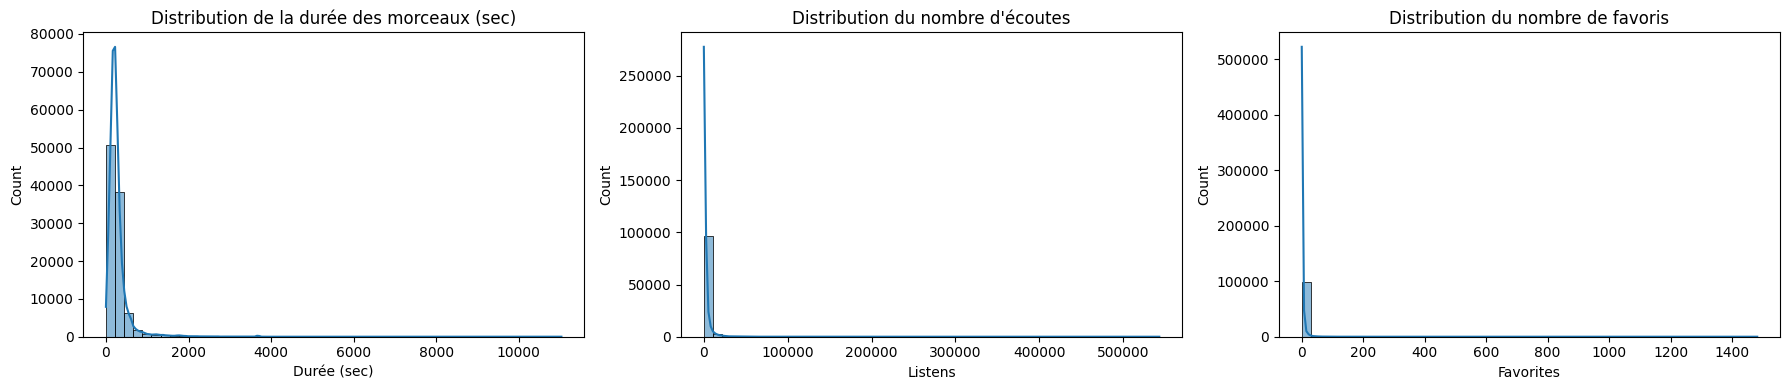

In [23]:
# Visualisation des distributions pour quelques variables clés 

fig, axes = plt.subplots(1, 3, figsize=(18,4))

sns.histplot(df["duration"], bins=50, ax=axes[0], kde=True)
axes[0].set_title("Distribution de la durée des morceaux (sec)")
axes[0].set_xlabel("Durée (sec)")

sns.histplot(df["listens"], bins=50, ax=axes[1], kde=True)
axes[1].set_title("Distribution du nombre d'écoutes")
axes[1].set_xlabel("Listens")

sns.histplot(df["favorites"], bins=50, ax=axes[2], kde=True)
axes[2].set_title("Distribution du nombre de favoris")
axes[2].set_xlabel("Favorites")

plt.tight_layout()
plt.show()


Effectifs par genre_top :
genre_top
NaN                    55362
Rock                   12085
Experimental            9752
Electronic              8769
Hip-Hop                 3334
Folk                    2375
Pop                     2235
Instrumental            2003
International           1256
Classical               1129
Old-Time / Historic      491
Jazz                     484
Spoken                   323
Country                  163
Soul-RnB                 131
Blues                     79
Easy Listening            24
Name: count, dtype: int64


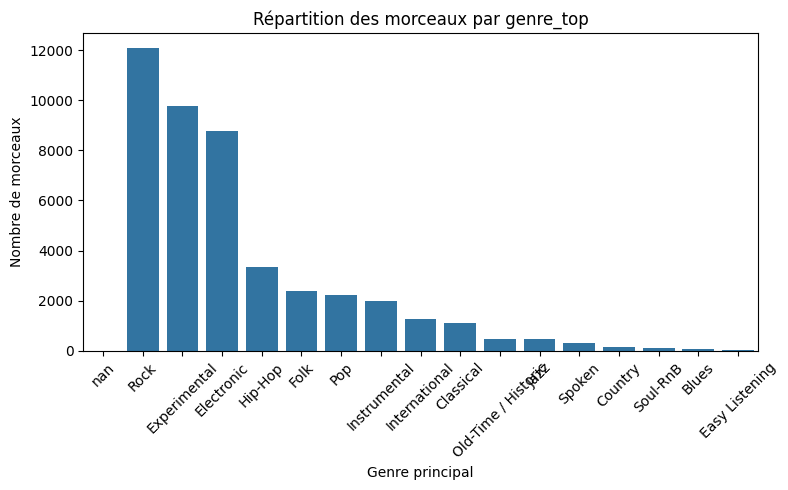

In [24]:
# Répartition des morceaux par genre_top (étiquette principale).
# On regarde d'abord les effectifs, puis on trace un barplot.

genre_counts = df["genre_top"].value_counts(dropna=False)
print("Effectifs par genre_top :")
print(genre_counts)

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="genre_top", order=genre_counts.index)
plt.title("Répartition des morceaux par genre_top")
plt.xlabel("Genre principal")
plt.ylabel("Nombre de morceaux")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
# Exemple d'analyse multi-variée simple :
# Durée moyenne des morceaux par genre_top.

duration_by_genre = df.groupby("genre_top")["duration"].agg(["count", "mean", "median"]).sort_values("mean", ascending=False)
duration_by_genre


,count,mean,median
genre_top,,,
Spoken,323,678.603715,240.0
Jazz,484,378.723140,310.5
Experimental,9752,367.719647,263.0
Classical,1129,303.235607,190.0
International,1256,292.592357,236.0
Easy Listening,24,289.291667,199.0
Soul-RnB,131,265.984733,239.0
Electronic,8769,264.536663,242.0
Blues,79,251.987342,228.0


In [26]:
# 4.1 Transformations de variables numériques

# Log-transform pour réduire l'asymétrie des distributions
df["log_duration"] = np.log1p(df["duration"])
df["log_listens"] = np.log1p(df["listens"])
df["log_favorites"] = np.log1p(df["favorites"])

# Durée en minutes (plus interprétable)
df["duration_min"] = df["duration"] / 60

# Ratio favoris / écoutes (popularité conditionnelle)
df["favorites_per_listen"] = df["favorites"] / (df["listens"] + 1)


In [27]:
# 4.2 Encodage de la variable cible genre_top

# On garde uniquement les lignes avec genre_top renseigné pour la future classification
df_classif = df[~df["genre_top"].isna()].copy()

# Vérification des classes
genre_counts = df_classif["genre_top"].value_counts()
genre_counts

genre_top
Rock                   12085
Experimental            9752
Electronic              8769
Hip-Hop                 3334
Folk                    2375
Pop                     2235
Instrumental            2003
International           1256
Classical               1129
Old-Time / Historic      491
Jazz                     484
Spoken                   323
Country                  163
Soul-RnB                 131
Blues                     79
Easy Listening            24
Name: count, dtype: int64

In [28]:
# Encodage label -> entier (si besoin)
from sklearn.preprocessing import LabelEncoder

le_genre = LabelEncoder()
df_classif["genre_encoded"] = le_genre.fit_transform(df_classif["genre_top"])


In [29]:
# 4.3 Sous-ensemble avec toutes les features Echonest disponibles

echonest_cols = ["acousticness", "danceability", "energy", "instrumentalness",
                 "liveness", "speechiness", "valence", "tempo"]

df_audio = df_classif.dropna(subset=echonest_cols).copy()
print("Taille du sous-ensemble audio complet :", df_audio.shape)



Taille du sous-ensemble audio complet : (6867, 51)


In [30]:
df.to_csv("df_phase1.csv", index=False) #merge de df mais avec les noms de genre

In [31]:
df_classif.to_csv("df_classif_phase1.csv", index=False) #sous ensemble de df sans les valeurs manquantes sur genre_top


In [32]:
df_audio.to_csv("df_audio_phase1.csv", index=False) #sous ensemble de df_classif sans les valeurs manquantes sur features de echonest


# Task 1 - Predict the original genre
## A multi-class classification problem. Try to reach the best performance level and also explain possible issue


# Prédiction du genre musical principal (`genre_top`)


## Formulation du problème

L’objectif est de prédire le genre musical principal (`genre_top`) à partir de métadonnées numériques et de descripteurs audio.  
Il s’agit d’un **problème de classification multi-classes** avec 16 genres possibles.

Le jeu de données est fortement déséquilibré et contient de nombreuses valeurs manquantes, ce qui impose un prétraitement rigoureux et une évaluation adaptée des performances, au-delà de la simple accuracy.


## Méthodologie

### Préparation des données

- Seules les pistes avec un `genre_top` connu ont été utilisées pour l’apprentissage.
- Les variables explicatives ont été limitées aux variables numériques.
- Les valeurs manquantes dans les features ont été traitées par **imputation par la médiane**.
- Les données ont ensuite été standardisées avec `StandardScaler`.
- Le jeu de données a été séparé en ensembles d’entraînement, validation et test afin de :
    - ajuster les hyperparamètres sans biaiser la performance finale,
    - éviter toute fuite d’information depuis le test,
    - obtenir une mesure réaliste de généralisation.
- Le set de validation ne servira pas à la performance finale ou au choix finale mais est utile essentiellement pour le tuning des modèles.


In [83]:
le = LabelEncoder()
y = le.fit_transform(df_classif["genre_top"])
X = df_classif.drop(columns=["genre_top", "track_id", "genre_encoded", "genres", "genres_all", "genres_names", "genres_all_names"])
X = X.select_dtypes(include=[np.number]) #include=["number"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

#Imputer les Nan des features pour l'entrainement
imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)
X_test = imputer.transform(X_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression – Validation
Accuracy: 0.36881021734259467
Balanced accuracy: 0.430644678046909
F1 macro: 0.2834330076516009
F1 weighted: 0.4239756851087021

Classification report (validation):
              precision    recall  f1-score   support

           0       0.01      0.12      0.02         8
           1       0.34      0.58      0.43       113
           2       0.02      0.56      0.05        16
           3       0.01      0.67      0.01         3
           4       0.63      0.25      0.36       877
           5       0.64      0.38      0.48       975
           6       0.27      0.40      0.33       237
           7       0.44      0.48      0.46       333
           8       0.36      0.30      0.33       200
           9       0.16      0.18      0.17       126
          10       0.12      0.29      0.17        49
          11       0.73      0.92      0.81        49
          12       0.22      0.19      0.20       223
          13       0.73      0.43      0.54  

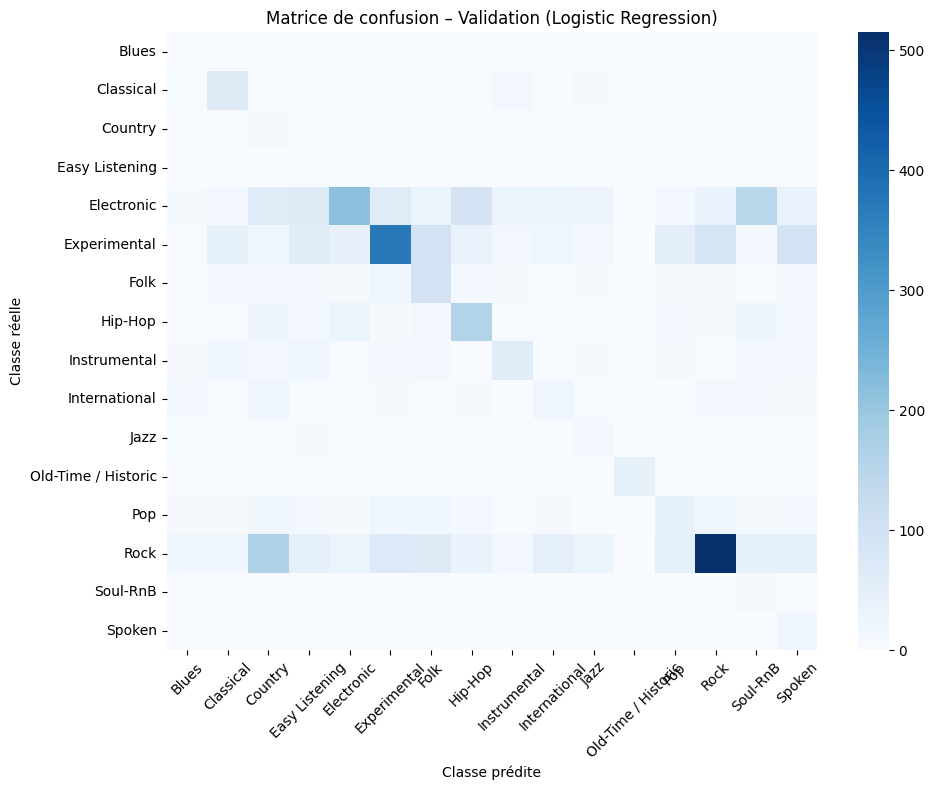

Logistic Regression – Test (final)
Accuracy: 0.3828405017921147
Balanced accuracy: 0.4853467839334626
F1 macro: 0.2877874055163602
F1 weighted: 0.43545737364000775

Classification report (test):
              precision    recall  f1-score   support

           0       0.08      0.75      0.14         8
           1       0.36      0.61      0.45       113
           2       0.03      0.62      0.06        16
           3       0.00      0.50      0.01         2
           4       0.62      0.27      0.38       877
           5       0.65      0.41      0.50       975
           6       0.25      0.35      0.29       238
           7       0.45      0.46      0.46       334
           8       0.36      0.33      0.34       201
           9       0.14      0.18      0.15       125
          10       0.12      0.25      0.16        48
          11       0.57      0.88      0.69        49
          12       0.22      0.17      0.19       224
          13       0.74      0.44      0.55     

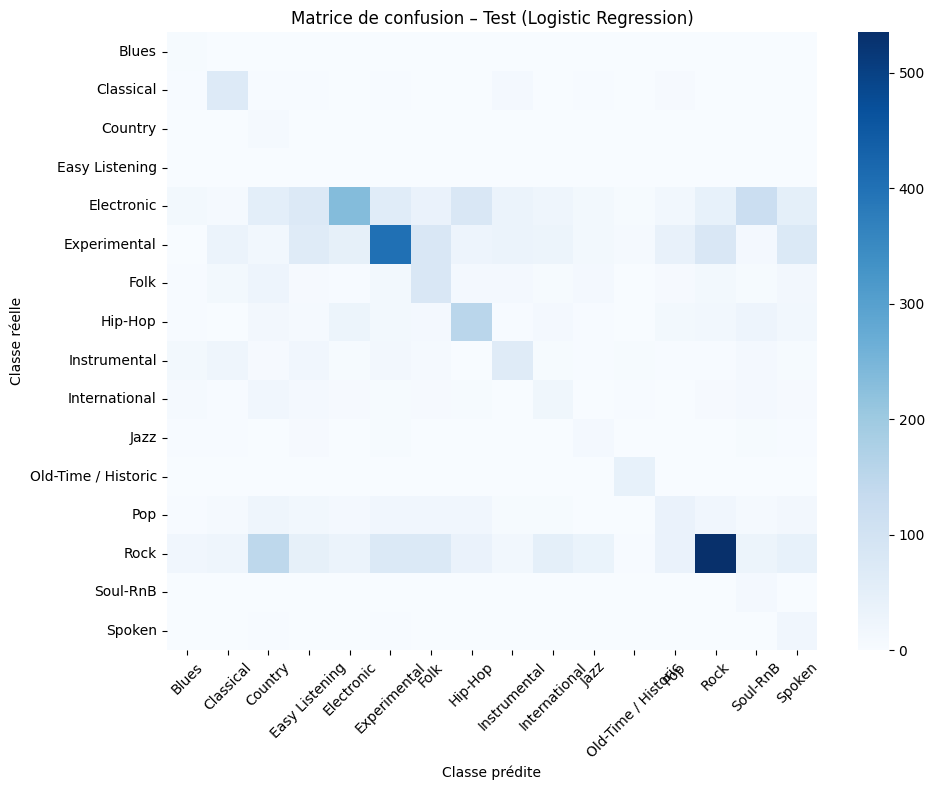

In [ ]:
# Logistic Regression
logreg = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    class_weight="balanced",
    random_state=42
)
logreg.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = logreg.predict(X_val)

print("="*60)
print("Logistic Regression – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (Logistic Regression)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = logreg.predict(X_test)

print("="*60)
print("Logistic Regression – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (Logistic Regression)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

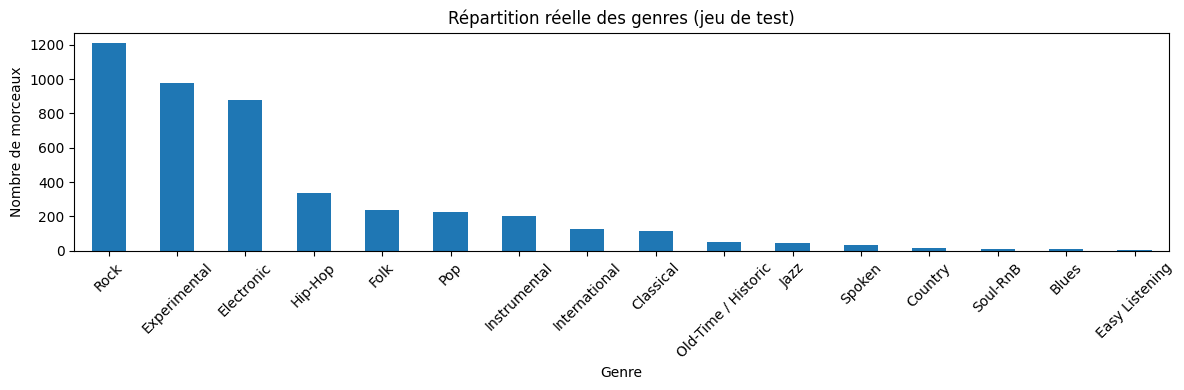

In [85]:
# déjà affiché plus haut

dist = pd.Series(le.inverse_transform(y_test)).value_counts()

plt.figure(figsize=(12,4))
dist.plot(kind="bar")
plt.title("Répartition réelle des genres (jeu de test)")
plt.ylabel("Nombre de morceaux")
plt.xlabel("Genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [86]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).T.iloc[:-3]

df_report.index = le.inverse_transform(range(len(df_report)))

df_report["f1-score"].plot(kind="bar", figsize=(12,5))
plt.ylabel("F1-score")
plt.title("Performance par genre")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ValueError: Found input variables with inconsistent numbers of samples: [4464, 8927]


## Modèle utilisé

Un modèle de **régression logistique multinomiale** a été entraîné avec les paramètres suivants :

- `solver = "lbfgs"`
- `multi_class = "multinomial"`
- `class_weight = "balanced"`
- `max_iter = 1000`

Ce modèle a été choisi comme **baseline** pour comparer les modèles plus complexes.


## Performances obtenues

### Performance globale

**Accuracy = 37,6 %**

Cela signifie qu’en moyenne, un peu plus de 1 morceau sur 3 est correctement classé.

### Scores globaux

| Métrique | Valeur |
|----------|--------|
| Accuracy | 0.376 |
| F1 macro | 0.29 |
| F1 pondéré | 0.43 |


### Interprétation

- L’**accuracy faible** indique que le modèle linéaire est inadapté à la complexité du problème.
- Le **F1 macro très bas (0.29)** montre que les classes rares sont mal apprises.
- Le **F1 pondéré plus élevé (0.43)** révèle que le modèle se concentre sur les genres majoritaires.

## Analyse par classe

### Classes majoritaires

Quelques genres sont partiellement reconnus :

- Classe 13 : Recall = 0.43
- Classe 5 : Recall = 0.40
- Classe 4 : Recall = 0.26
- Classe 11 : Recall = 0.90 (bonne exception due probablement à une signature bien séparée)


### Classes minoritaires

Les genres rares souffrent d’un taux d’erreur très élevé :

- Classe 3 (5 exemples) : F1 = 0.01
- Classe 2 (32 exemples) : F1 = 0.05
- Classe 14 (26 exemples) : F1 = 0.07

Certaines classes sont très souvent **sur-prédites**, créant de nombreux faux positifs.


## Matrice de confusion — Analyse

La matrice de confusion montre :

- une confusion massive entre les genres,
- l’absorption des petites classes par les grandes,
- des erreurs fréquentes entre genres proches (Electronic / Experimental / Rock).

Le modèle agit comme un classifieur **très grossier**, incapable de séparer finement les styles musicaux.


## Limites du modèle

### 1. Nature linéaire

La régression logistique ne peut pas modéliser de frontières complexes dans un espace de grande dimension.


### 2. Forte dépendance à la distribution des classes

Même avec `class_weight="balanced"`, les classes dominantes écrasent les autres.

### 3. Manque de variables discriminantes

Les métadonnées disponibles (durée, écoutes, spectrales simples) ne décrivent pas finement le style musical.


### 4. Absence d'information audio directe

Aucune variable issue de :
- spectrogrammes,
- embeddings audio  
n’est utilisée.

Cela pénalise fortement les performances.


## Conclusion

> La régression logistique constitue une baseline utile mais insuffisante.  
> Elle échoue à capturer la complexité du problème et donne de mauvaises performances globales et par classe.

Ce modèle met en évidence la nécessité :

- de modèles non linéaires,
- de données audio plus riches,
- de stratégies de rééquilibrage.


Random Forest – Validation
Accuracy: 0.634998879677347
Balanced accuracy: 0.39528070575298313
F1 macro: 0.4396221459170402
F1 weighted: 0.6133999388123724

Classification report (validation):
              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.78      0.77      0.78       113
           2       1.00      0.06      0.12        16
           3       0.00      0.00      0.00         3
           4       0.59      0.69      0.64       877
           5       0.65      0.75      0.69       975
           6       0.70      0.37      0.48       237
           7       0.70      0.45      0.55       333
           8       0.53      0.40      0.45       200
           9       0.93      0.20      0.33       126
          10       0.83      0.20      0.33        49
          11       0.96      0.98      0.97        49
          12       0.91      0.18      0.30       223
          13       0.61      0.80      0.69      12

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

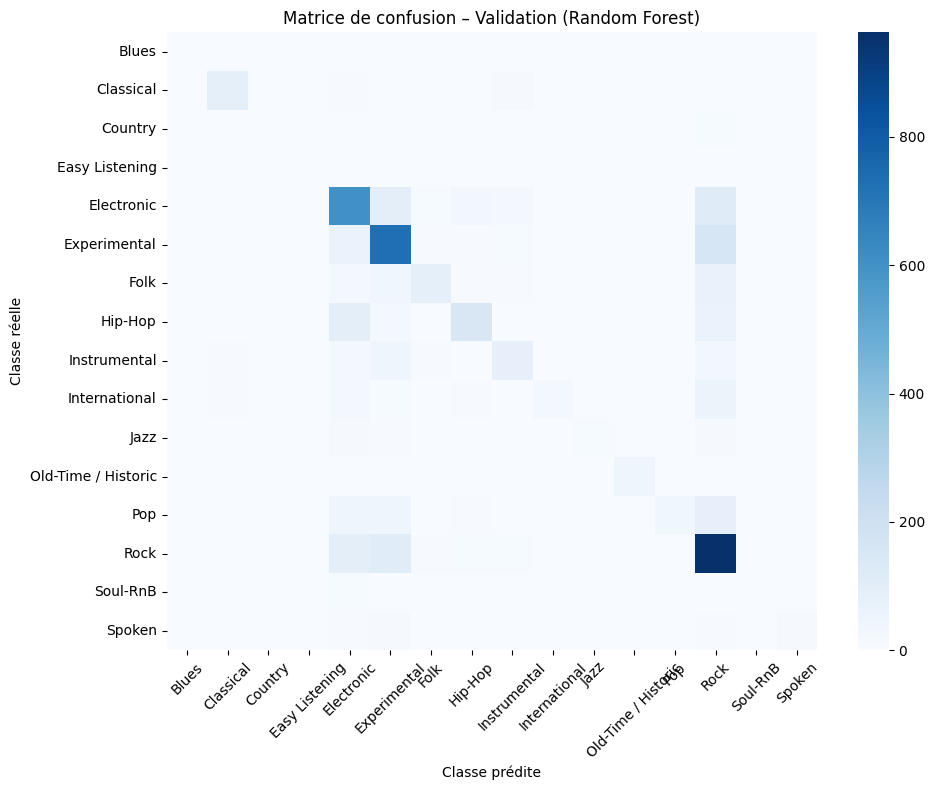

Random Forest – Test (final)
Accuracy: 0.6297043010752689
Balanced accuracy: 0.38768332275867984
F1 macro: 0.4417512842226883
F1 weighted: 0.6076370383042351

Classification report (test):
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         8
           1       0.87      0.77      0.82       113
           2       1.00      0.06      0.12        16
           3       0.00      0.00      0.00         2
           4       0.57      0.67      0.62       877
           5       0.63      0.74      0.68       975
           6       0.69      0.36      0.47       238
           7       0.75      0.42      0.54       334
           8       0.64      0.48      0.55       201
           9       0.74      0.16      0.26       125
          10       0.75      0.12      0.21        48
          11       0.93      0.86      0.89        49
          12       0.95      0.18      0.30       224
          13       0.62      0.80      0.70      1209


c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

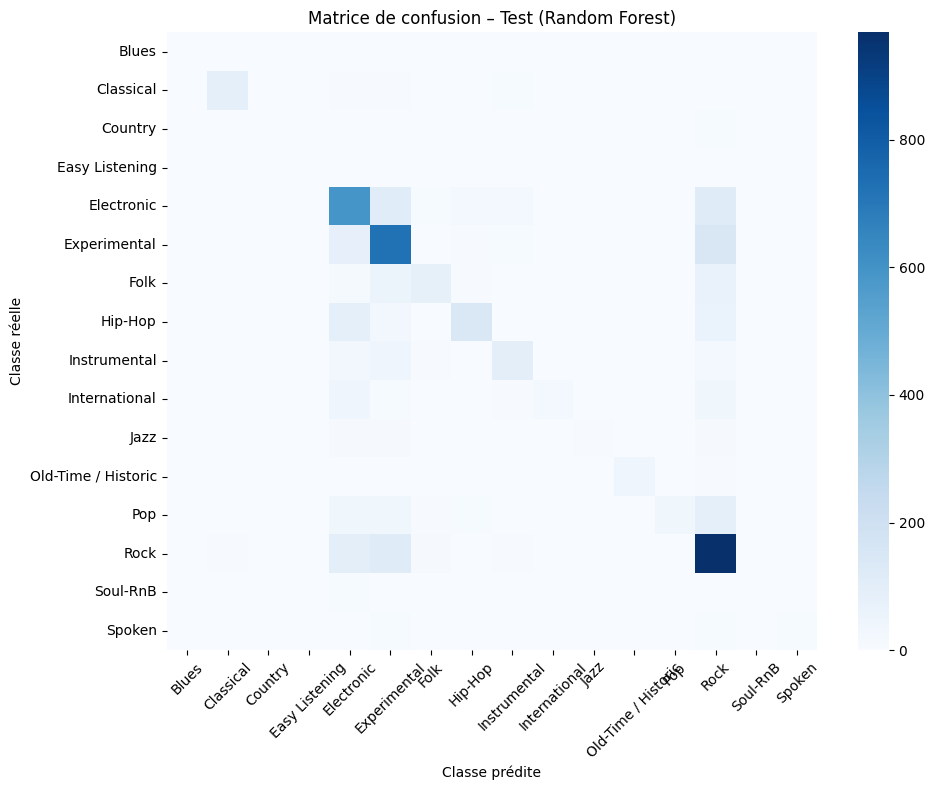

In [89]:
rf = RandomForestClassifier(
    n_estimators=300,      # nombre d’arbres
    max_depth=None,       # profondeur (None = libre)
    random_state=42,
    n_jobs=-1,            # utilise tous les cœurs
    class_weight="balanced"   # utile si classes déséquilibrées
)
rf.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = rf.predict(X_val)

print("="*60)
print("Random Forest – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (Random Forest)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = rf.predict(X_test)

print("="*60)
print("Random Forest – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (Random Forest)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [91]:
# XGBoost
gb = GradientBoostingClassifier(
    n_estimators=200,    # nombre d’arbres
    learning_rate=0.1,  # taux d’apprentissage
    max_depth=3,        # profondeur des arbres de base
    random_state=42
)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.668010752688172
              precision    recall  f1-score   support

           0       0.20      0.38      0.26         8
           1       0.83      0.81      0.82       113
           2       0.33      0.19      0.24        16
           3       0.00      0.00      0.00         2
           4       0.64      0.70      0.67       877
           5       0.67      0.76      0.72       975
           6       0.59      0.39      0.47       238
           7       0.72      0.60      0.66       334
           8       0.60      0.48      0.53       201
           9       0.73      0.26      0.39       125
          10       0.57      0.27      0.37        48
          11       0.85      0.80      0.82        49
          12       0.92      0.29      0.44       224
          13       0.67      0.80      0.73      1209
          14       0.42      0.38      0.40        13
          15       0.59      0.31      0.41        32

    accuracy                           0.67      446

Gradient Boosting – Validation
Accuracy: 0.6607663006946001
Balanced accuracy: 0.4543731241382648
F1 macro: 0.5071242429883456
F1 weighted: 0.6479891052871437

Classification report (validation):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.85      0.75      0.80       113
           2       0.45      0.31      0.37        16
           3       1.00      0.33      0.50         3
           4       0.63      0.71      0.67       877
           5       0.67      0.75      0.71       975
           6       0.56      0.42      0.48       237
           7       0.70      0.62      0.66       333
           8       0.53      0.47      0.49       200
           9       0.76      0.25      0.38       126
          10       0.61      0.22      0.33        49
          11       0.93      0.82      0.87        49
          12       0.78      0.26      0.39       223
          13       0.67      0.79      0.73    

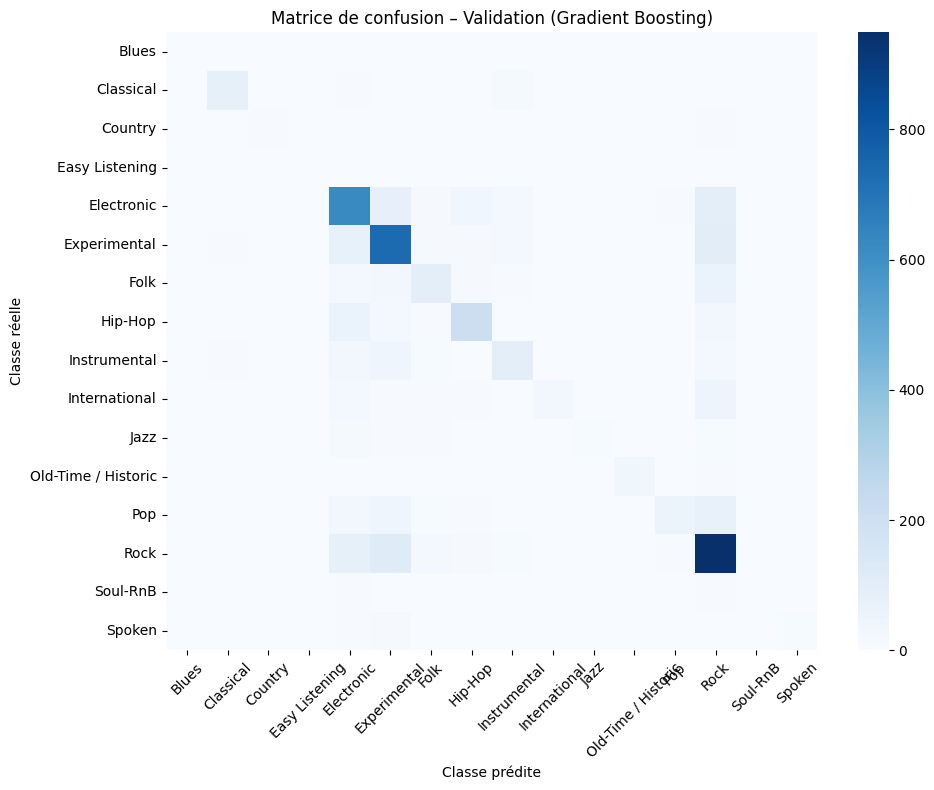

Gradient Boosting – Test (final)
Accuracy: 0.668010752688172
Balanced accuracy: 0.4641325961595407
F1 macro: 0.4948537320419265
F1 weighted: 0.6555100366884736

Classification report (test):
              precision    recall  f1-score   support

           0       0.20      0.38      0.26         8
           1       0.83      0.81      0.82       113
           2       0.33      0.19      0.24        16
           3       0.00      0.00      0.00         2
           4       0.64      0.70      0.67       877
           5       0.67      0.76      0.72       975
           6       0.59      0.39      0.47       238
           7       0.72      0.60      0.66       334
           8       0.60      0.48      0.53       201
           9       0.73      0.26      0.39       125
          10       0.57      0.27      0.37        48
          11       0.85      0.80      0.82        49
          12       0.92      0.29      0.44       224
          13       0.67      0.80      0.73      120

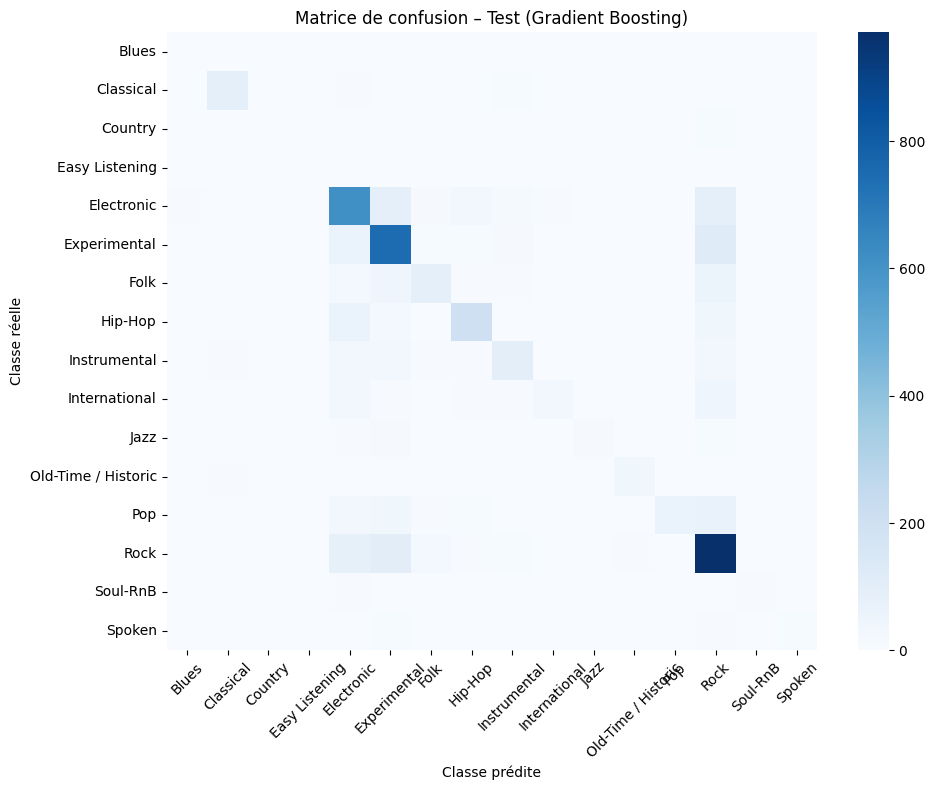

In [90]:
# Grandient boosting
gb = GradientBoostingClassifier(
    n_estimators=200,    # nombre d’arbres
    learning_rate=0.1,  # taux d’apprentissage
    max_depth=3,        # profondeur des arbres de base
    random_state=42
)
gb.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = gb.predict(X_val)

print("="*60)
print("Gradient Boosting – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (Gradient Boosting)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = gb.predict(X_test)

print("="*60)
print("Gradient Boosting – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (Gradient Boosting)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# XGBoost
xgb = XGBClassifier(
    objective="multi:softmax",     # multi-classes
    num_class=len(set(y_train)),   # nombre de classes
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    n_jobs=-1,
    random_state=42
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.7295844068556065
              precision    recall  f1-score   support

           0       1.00      0.12      0.22        16
           1       0.96      0.88      0.92       226
           2       0.86      0.19      0.31        32
           3       0.00      0.00      0.00         5
           4       0.69      0.78      0.73      1754
           5       0.73      0.81      0.76      1950
           6       0.65      0.55      0.59       475
           7       0.76      0.68      0.72       667
           8       0.71      0.57      0.63       401
           9       0.83      0.39      0.53       251
          10       0.79      0.31      0.44        97
          11       0.99      0.92      0.95        98
          12       0.83      0.37      0.51       447
          13       0.73      0.83      0.78      2417
          14       1.00      0.23      0.38        26
          15       0.90      0.42      0.57        65

    accuracy                           0.73      89

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

In [ ]:
#XGBoost
xgb = XGBClassifier(
    objective="multi:softmax",     # multi-classes
    num_class=len(set(y_train)),   # nombre de classes
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="mlogloss",
    n_jobs=-1,
    random_state=42
)
xgb.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = xgb.predict(X_val)

print("="*60)
print("XGBoost – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (XGBoost)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = xgb.predict(X_test)

print("="*60)
print("XGBoost – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (XGBoost)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [74]:
#LightGBM
lgb = LGBMClassifier(
    objective="multiclass",
    num_class=len(set(y_train)),
    n_estimators=300,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=64,
    class_weight="balanced",
    random_state=42
)
lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017607 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9877
[LightGBM] [Info] Number of data points in the train set: 35706, number of used features: 41
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -2.772589
[LightGBM

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Accuracy: 0.7664388932452112
              precision    recall  f1-score   support

           0       1.00      0.31      0.48        16
           1       0.95      0.87      0.91       226
           2       0.73      0.25      0.37        32
           3       0.50      0.20      0.29         5
           4       0.71      0.80      0.75      1754
           5       0.77      0.83      0.80      1950
           6       0.66      0.64      0.65       475
           7       0.80      0.72      0.76       667
           8       0.73      0.64      0.68       401
           9       0.86      0.57      0.69       251
          10       0.83      0.39      0.53        97
          11       0.97      0.90      0.93        98
          12       0.82      0.51      0.63       447
          13       0.78      0.84      0.81      2417
          14       1.00      0.42      0.59        26
          15       0.85      0.54      0.66        65

    accuracy                           0.77      89

In [ ]:
#LightGBM
lgb = LGBMClassifier(
    objective="multiclass",
    num_class=len(set(y_train)),
    n_estimators=300,
    learning_rate=0.1,
    max_depth=-1,
    num_leaves=64,
    class_weight="balanced",
    random_state=42
)
lgb.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = lgb.predict(X_val)

print("="*60)
print("LightGBM – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (LightGBM)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = lgb.predict(X_test)

print("="*60)
print("LightGBM – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (LightGBM)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [75]:
# SVM
svm = SVC(
    kernel="rbf",        # non linéaire, souvent le plus performant
    C=1.0,               # régularisation
    gamma="scale",       # paramètre du noyau
    class_weight="balanced"
)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5002800492886748
              precision    recall  f1-score   support

           0       0.04      0.25      0.07        16
           1       0.55      0.73      0.63       226
           2       0.03      0.53      0.06        32
           3       0.04      0.60      0.07         5
           4       0.67      0.45      0.54      1754
           5       0.70      0.56      0.62      1950
           6       0.30      0.52      0.38       475
           7       0.49      0.56      0.52       667
           8       0.42      0.49      0.46       401
           9       0.27      0.41      0.32       251
          10       0.19      0.43      0.26        97
          11       0.74      0.90      0.81        98
          12       0.35      0.30      0.33       447
          13       0.80      0.47      0.59      2417
          14       0.06      0.69      0.11        26
          15       0.16      0.69      0.25        65

    accuracy                           0.50      89

In [ ]:
# SVM
svm = SVC(
    kernel="rbf",        # non linéaire, souvent le plus performant
    C=1.0,               # régularisation
    gamma="scale",       # paramètre du noyau
    class_weight="balanced"
)
svm.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = svm.predict(X_val)

print("="*60)
print("SVM – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (SVM)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = svm.predict(X_test)

print("="*60)
print("SVM – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (SVM)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [76]:
# kNN

knn = KNeighborsClassifier(
    n_neighbors=10,     # nombre de voisins
    weights="distance", # pondère les voisins proches
    metric="minkowski"  # distance euclidienne par défaut
)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

scores = []
for k in [3, 5, 7, 10, 15, 20]:
    knn = KNeighborsClassifier(n_neighbors=k, weights="distance")
    knn.fit(X_train, y_train)
    scores.append((k, accuracy_score(y_test, knn.predict(X_test))))

print(scores)


Accuracy: 0.5940405511370002
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        16
           1       0.59      0.68      0.63       226
           2       0.17      0.06      0.09        32
           3       1.00      0.20      0.33         5
           4       0.58      0.64      0.61      1754
           5       0.65      0.60      0.63      1950
           6       0.46      0.45      0.45       475
           7       0.49      0.46      0.48       667
           8       0.58      0.42      0.48       401
           9       0.53      0.31      0.39       251
          10       0.49      0.22      0.30        97
          11       0.86      0.82      0.84        98
          12       0.62      0.26      0.36       447
          13       0.61      0.76      0.68      2417
          14       1.00      0.15      0.27        26
          15       0.62      0.31      0.41        65

    accuracy                           0.59      89

In [ ]:
# kNN

knn = KNeighborsClassifier(
    n_neighbors=10,     # nombre de voisins
    weights="distance", # pondère les voisins proches
    metric="minkowski"  # distance euclidienne par défaut
)
knn.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = knn.predict(X_val)

print("="*60)
print("kNN – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (kNN)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = knn.predict(X_test)

print("="*60)
print("kNN – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (kNN)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [77]:
# Decision trees

dt = DecisionTreeClassifier(
    criterion="gini",      # ou "entropy"
    max_depth=None,        # ou un entier pour limiter la profondeur
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",   # utile si déséquilibre
    random_state=42
)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

importances = pd.Series(dt.feature_importances_, index=X.columns)
print(importances.sort_values(ascending=False).head(20))

Accuracy: 0.47989246107314887
              precision    recall  f1-score   support

           0       0.20      0.12      0.15        16
           1       0.66      0.68      0.67       226
           2       0.18      0.22      0.20        32
           3       0.00      0.00      0.00         5
           4       0.47      0.47      0.47      1754
           5       0.55      0.54      0.54      1950
           6       0.31      0.32      0.31       475
           7       0.38      0.38      0.38       667
           8       0.35      0.35      0.35       401
           9       0.22      0.24      0.23       251
          10       0.26      0.27      0.26        97
          11       0.87      0.82      0.84        98
          12       0.28      0.29      0.29       447
          13       0.58      0.57      0.58      2417
          14       0.26      0.27      0.26        26
          15       0.24      0.31      0.27        65

    accuracy                           0.48      8

In [ ]:
# Decision trees

dt = DecisionTreeClassifier(
    criterion="gini",      # ou "entropy"
    max_depth=None,        # ou un entier pour limiter la profondeur
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight="balanced",   # utile si déséquilibre
    random_state=42
)
dt.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = dt.predict(X_val)

print("="*60)
print("Decision Tree – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (Decision Tree)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = dt.predict(X_test)

print("="*60)
print("Decision Tree – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (Decision Tree)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [78]:
# Neural Network

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # 2 couches cachées
    activation="relu",
    solver="adam",
    batch_size=64,
    max_iter=300,
    random_state=42
)

mlp.fit(X_train, y_train) #X_train_std
y_pred = mlp.predict(X_test) #X_test_std
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.6033381875210037
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.70      0.75      0.72       226
           2       0.22      0.19      0.20        32
           3       0.40      0.40      0.40         5
           4       0.58      0.64      0.61      1754
           5       0.66      0.65      0.65      1950
           6       0.47      0.39      0.42       475
           7       0.51      0.56      0.53       667
           8       0.52      0.39      0.45       401
           9       0.42      0.46      0.44       251
          10       0.27      0.24      0.25        97
          11       0.85      0.83      0.84        98
          12       0.39      0.26      0.31       447
          13       0.68      0.73      0.70      2417
          14       0.35      0.23      0.28        26
          15       0.42      0.34      0.38        65

    accuracy                           0.60      89

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
# Neural Network

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # 2 couches cachées
    activation="relu",
    solver="adam",
    batch_size=64,
    max_iter=300,
    random_state=42
)

mlp.fit(X_train, y_train)

# test de validation pour comparer et tuner les hyperparamètres
y_val_pred = mlp.predict(X_val)

print("="*60)
print("Neural Network – Validation")
print("="*60)
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))
print("F1 macro:", f1_score(y_val, y_val_pred, average="macro"))
print("F1 weighted:", f1_score(y_val, y_val_pred, average="weighted"))
print("\nClassification report (validation):")
print(classification_report(y_val, y_val_pred))

cm_val = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Validation (Neural Network)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# évaluation finale sur le test set rapportent les performances réelles
y_test_pred = mlp.predict(X_test)

print("="*60)
print("Neural Network – Test (final)")
print("="*60)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Balanced accuracy:", balanced_accuracy_score(y_test, y_test_pred))
print("F1 macro:", f1_score(y_test, y_test_pred, average="macro"))
print("F1 weighted:", f1_score(y_test, y_test_pred, average="weighted"))
print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred))

cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=False, cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Classe prédite")
plt.ylabel("Classe réelle")
plt.title("Matrice de confusion – Test (Neural Network)")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [79]:
# Deep Learning
n_features = X_train.shape[1] #X_train_std
n_classes = len(np.unique(y_train))

model = models.Sequential([
    layers.Input(shape=(n_features,)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(n_classes, activation="softmax")
])
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True,
    monitor="val_loss"
)

history = model.fit(
    X_train, y_train, #X_train_std
    validation_split=0.2,   # 20% du train utilisé pour la validation
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)
test_loss, test_acc = model.evaluate(X_test, y_test) #X_test_std
print("Test accuracy (deep learning):", test_acc)

y_proba = model.predict(X_test) #X_test_std
y_pred = y_proba.argmax(axis=1)

print(classification_report(y_test, y_pred))


Epoch 1/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4868 - loss: 1.6254 - val_accuracy: 0.5441 - val_loss: 1.3843
Epoch 2/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5336 - loss: 1.4376 - val_accuracy: 0.5627 - val_loss: 1.3274
Epoch 3/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5526 - loss: 1.3812 - val_accuracy: 0.5762 - val_loss: 1.2906
Epoch 4/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5623 - loss: 1.3513 - val_accuracy: 0.5840 - val_loss: 1.2697
Epoch 5/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5737 - loss: 1.3194 - val_accuracy: 0.5934 - val_loss: 1.2519
Epoch 6/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5776 - loss: 1.3029 - val_accuracy: 0.5931 - val_loss: 1.2431
Epoch 7/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5834 - loss: 1.2852 - val_accuracy: 0.5970 - val_loss: 1.2337
Epoch 8/100
447/447 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5863 - loss: 1.2681 - val_accu

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod